# Creating an Ensemble Model

#### Marlena Bannick and Madeline McGaughey
##### *Institute for Health Metrics and Evaluation*

### Setup

In [350]:
%load_ext autoreload
%autoreload 2

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [351]:
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pylab
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [352]:
np.random.seed(19404)

Load ensemble package

In [353]:
from ensemble.submodel import Submodel
from ensemble.ensemble import Ensemble
from ensemble import utilities

Load data from the data directory

In [354]:
cd ~/repos/simple-ensemble/notebooks

/Users/mnorwood/repos/simple-ensemble/notebooks


In [355]:
workdir = '../data/'
data_frame = pd.read_csv(os.path.join(workdir, 'data-3.csv'))
cv_names = utilities.import_cv_vars(os.path.join(workdir, 'cv_selected.txt'))['rate_vars']

data_frame = data_frame.loc[data_frame.year.isin(list(range(1990, 2005)))].copy()

In [356]:
data_frame['ln_LDI_pc'] = np.log(data_frame['LDI_pc'])
data_frame['ln_omega_3_g_adj'] = np.log(data_frame['omega_3_g_adj'])
data_frame['ln_vegetables_g_adj'] = np.log(data_frame['vegetables_g_adj'])

In [357]:
data_frame.to_csv('../data/data-3.csv', index=False)

### The Ensemble Story

#### *Our Purpose*

Vital  registration  systems,  verbal  autopsies,  disease  registries  and  police  reports  are  all  examples  of  the diverse data sources that exist to record who is dying from what disease or injury.  We do not always have cause of death data available for all locations and demographic groups.  Even when we do, these data sources are imperfect.  The goal of the Cause of Death Ensemble Model (CODEm) used in the Global Burden of Disease Study (GBD) is to synthesize all of the heterogeneous data sources from around the world to make the best, most comprehensive estimates for a specific cause of death.

In the absence of complete data, we need to use other information in the form of model covariates to help predict cause of death. Some diseases and injuries have variables with which they are strongly associated (e.g. prevalence of smoking is strongly associated with lung cancer death rate).  In other cases, variables may have ambiguous, but plausible, associations with a certain cause of death.  Different causes of death may also follow different data generating processes and thus are better approximated by different types of models.

As a motivating example and teaching exercise, we will use the approach of CODEm, in a simplified format, to predict as accurately as possible the mortality from ischemic heart disease in females in the United States from 1990-2005.

#### *The Non-Ensemble Modeling Approach*

##### Classifier Specification

A disease modeler with epidemiological expertise in cardiovascular diseases might have some prior knowledge about variables that they think are likely to be associated with heart disease mortality at the population level. These might be based on known relationships between individual-level factors like BMI and cholesterol. They could also include more distantly related variables like the overall socioeconomic status of the state that someone lives in, or the amount of air pollution.

Using some knowledge about potential covariates, and adding a random effect for age (to capture systematic variation in IHD mortality that is not captured by the covariates in the model), we can fit a mixed effects linear model on all of the available vital registration data for the United States. Throughout this example, to be consistent with `scikit-learn` terminology, we will call a model like this "classifier": a statistical model that is used to predict a response variable.

We will use `mixedlm`, a module from the Python `statsmodels` package, to fit this linear mixed effects model. The formal specification of this model is given by the following equation

\begin{align*}
y = X\beta + Z \upsilon + \epsilon
\end{align*}

Where $y$ is a vector of the response variable in the model (e.g. death rate) with one entry for each location-year-age group, $X$ is a design matrix of covariates to predict the response (and column of 1's to specify an intercept), $\beta$ is a vector of fixed-effects, $Z$ is a vector specifying the group to which each observation belongs (in this case we are using age as the random effect), $\upsilon$ is a the error term around the random effect, and $\epsilon$ is a normally distributed, independent error, i.e. $\epsilon \sim N_n(0, \sigma^2)$ with $\sigma^2$ to be estimated. Documentation on the syntax used to fit this type of model with `statsmodels` is available [here](http://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html).

For a given set of covariates, age as a random effect, and the log of the death rate as our respnose, we have the following objects that we will use to fit our model. Let's pick one set of covariates to start with: mean cholesterol, Healthcare Access and Quality Index, outdoor pollution (measured in PM2.5), and the proportion of the population that lives at or above 1500 meters.

**First some pre-processing of the data.**

All of the data is publicly available for download from the following links:
- Population data: http://ghdx.healthdata.org/record/ihme-data/gbd-2017-population-estimates-1950-2017
- All-cause mortality data: http://ghdx.healthdata.org/gbd-results-tool
- Cause-specific mortality data: https://vizhub.healthdata.org/cod/
- Covariate data: https://cloud.ihme.washington.edu/index.php/s/NEZgMdLQxpTziiP?path=%2FGBD%202017%20Covariates

We have downloaded the data for all U.S. states, females, Ischemic Heart Disease, from 1990-2017. We have merged them together for one large dataset that is available in the repository here: https://github.com/mbannick/simple-ensemble/tree/master/data/all_data.csv.

The data frame has the following columns:

In [358]:
data_frame.columns

Index(['location', 'sex', 'age', 'year', 'pop', 'cause_fraction', 'LDI_pc',
       'SEV_scalar_IHD', 'alcohol_lpc', 'diabetes_fpg', 'fruits_g_adj', 'haqi',
       'mean_BMI', 'mean_SBP', 'mean_cholesterol', 'nuts_seeds_g_adj',
       'omega_3_g_adj', 'pollution_indoor_total_prev',
       'pollution_outdoor_pm25', 'pop_1500mplus_prop', 'pufa_adj_pct',
       'pulses_legumes_g_adj', 'smoking_prev', 'tfa', 'vegetables_g_adj',
       'envelope', 'sdi', 'rate', 'ln_rate', 'lt_cf', 'ln_LDI_pc',
       'ln_omega_3_g_adj', 'ln_vegetables_g_adj'],
      dtype='object')

`location`, `sex`, `age`, and `year` are the demographic identifiers. `cause_fraction` is the fraction fo the deaths in that demographic group due to ischemic heart disease. `envelope` is the total number of deaths in that demographic group. `pop` is the total population in that demographic group.

Let's make a log rate variable, `ln_rate`. Predicting in log rate spaces is easier than predicting in cause fraction space, because the predictions can span the full real line.

In [359]:
data_frame['rate'] = data_frame['cause_fraction'].values * data_frame['envelope'].values / data_frame['pop'].values
data_frame['ln_rate'] = np.log(data_frame['rate'].values)

In [360]:
# create a list of covariate names
cv = ['mean_cholesterol', 'haqi', 'pollution_outdoor_pm25', 'pop_1500mplus_prop']

# subset the dataset to only the necessary columns
cols = ['location', 'age', 'year', 'ln_rate'] + cv
df = data_frame[cols]
df.head()

,location,age,year,ln_rate,mean_cholesterol,haqi,pollution_outdoor_pm25,pop_1500mplus_prop
0,Alabama,15 to 19,1990,-12.496447,5.342842,76.697596,11.072353,0.0
1,Alabama,20 to 24,1990,-12.053957,5.342842,76.697596,11.072353,0.0
2,Alabama,25 to 29,1990,-10.734324,5.342842,76.697596,11.072353,0.0
3,Alabama,30 to 34,1990,-10.725036,5.342842,76.697596,11.072353,0.0
4,Alabama,35 to 39,1990,-9.397679,5.342842,76.697596,11.072353,0.0


We have created an object class called `Submodel` that takes in all of the ingredients we need to fit this model and make our best predictions for heart disease mortality. Let's start by instantiating the classifier that we want to use, and assigning it the attributes specific to this model. We can check out our new classifier and look at its attributes that will be used to fit the model.

In [361]:
# create a Submodel object and retrieve its parameters
model = Submodel(response='ln_rate', fixed_effects=cv, random_effects=['age'])
model.get_params()

{'fixed_effects': ['mean_cholesterol',
  'haqi',
  'pollution_outdoor_pm25',
  'pop_1500mplus_prop'],
 'random_effects': ['age'],
 'response': 'ln_rate'}

In [362]:
# retrieve the model formula that will be used
model.formula

'ln_rate ~ + mean_cholesterol + haqi + pollution_outdoor_pm25 + pop_1500mplus_prop + (1|age) '

##### Single Classifier In-Sample Predictions

The `Submodel` class has functions to fit the model on a given dataset, and then predict on the same, or another dataset. Everytime we run `Submodel.fit()`, it will update the parameter estimates of the classifier. Let's fit our model to the dataset and then predict on the same dataset.

In [363]:
# fit the classifier to the dataset from above
model.fit(df)

Submodel(fixed_effects=['mean_cholesterol', 'haqi', 'pollution_outdoor_pm25', 'pop_1500mplus_prop'],
     random_effects=['age'], response='ln_rate')

In [364]:
# view the parameter estimates for the covariates
model.betas

array([-4.84910642e+00,  6.30904517e-05, -3.39661425e-02,  5.94550334e-02,
       -4.28516385e-02])

In [365]:
# view the predictions for the model
predictions = model.predict(df)
predictions

array([-12.25712175, -11.51390757, -10.82696033, ...,  -3.7875881 ,
        -3.20184673,  -2.5018255 ])

In [366]:
model.rmse(df)

INFO:ensemble.submodel:Computing RMSE.


0.23907513422501578

A commonly used metric to assess the goodness-of-fit of a model is root-mean-squared-error (RMSE). It is calculated as the sum of the squared deviations of the predictions from the raw data. With $\hat{y}_i$ and $y_i$ as the prediction and raw data for observation $i$ out of $n$ observations, RMSE is calculated as follows:

\begin{align*}
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n (\hat{y}_i - y_i)^2}
\end{align*}

Using the `rmse` function in the `Submodel` class, we can calculate the RMSE for the predictions that we just made.

To get another view of the predictions, we can plot the predictions for a few age-locations over time. We will look at Georgia, for age groups 60-64, 65-69, 70-74, and 75-79 from 1990-2005. We can see in the plot below that our predictions are capturing the overall trend of the data, but it's not doing as well as we might expect. You can see the effect of age, that adding a random effect just increases or decreases the intercept, but the shape of the line doesn't change.

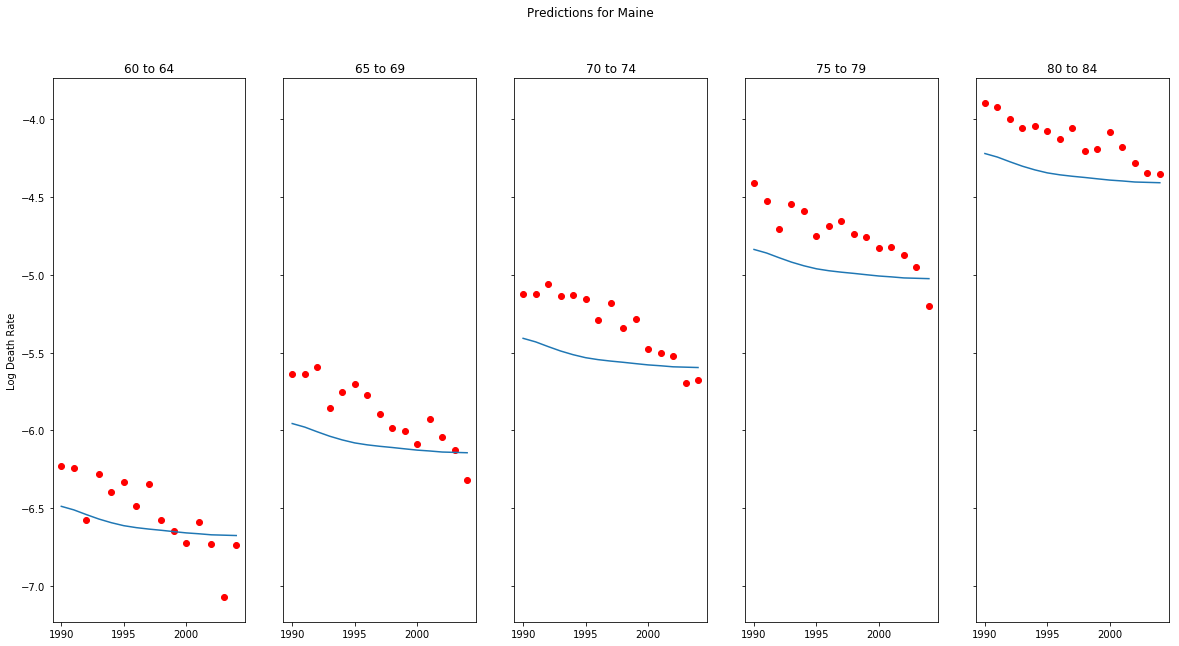

In [367]:
model.plot_predictions(df, querystring='location == "Maine"',
                       ages=['60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 to 84'])

What if other covariates could do a better job than the ones that we have pre-specified as being associated with heart disease mortality? Could we include more covariates in the model to make our predictions better? Let's try putting in a whole bunch of covariates that could be associated with heart disease mortality.

In [368]:
# create a list of covariate names
cv = ['alcohol_lpc', 'diabetes_fpg', 'mean_BMI', 'mean_cholesterol', 'mean_SBP', 'pollution_indoor_total_prev', 'pollution_outdoor_pm25',
      'pop_1500mplus_prop', 'smoking_prev', 'SEV_scalar_IHD', 'sdi', 'fruits_g_adj',
      'nuts_seeds_g_adj', 'pufa_adj_pct', 'pulses_legumes_g_adj', 'haqi', 'tfa', 'ln_LDI_pc', 'ln_omega_3_g_adj', 'ln_vegetables_g_adj']

In [369]:
# create a Submodel object and retrieve its parameters
model = Submodel(response='ln_rate', fixed_effects=cv, random_effects=['age'])

In [370]:
data_frame.columns

Index(['location', 'sex', 'age', 'year', 'pop', 'cause_fraction', 'LDI_pc',
       'SEV_scalar_IHD', 'alcohol_lpc', 'diabetes_fpg', 'fruits_g_adj', 'haqi',
       'mean_BMI', 'mean_SBP', 'mean_cholesterol', 'nuts_seeds_g_adj',
       'omega_3_g_adj', 'pollution_indoor_total_prev',
       'pollution_outdoor_pm25', 'pop_1500mplus_prop', 'pufa_adj_pct',
       'pulses_legumes_g_adj', 'smoking_prev', 'tfa', 'vegetables_g_adj',
       'envelope', 'sdi', 'rate', 'ln_rate', 'lt_cf', 'ln_LDI_pc',
       'ln_omega_3_g_adj', 'ln_vegetables_g_adj'],
      dtype='object')

In [371]:
# subset the dataset to only the necessary columns
cols = ['location', 'age', 'year', 'ln_rate'] + cv
df = data_frame[cols]
model.fit(df)

Submodel(fixed_effects=['alcohol_lpc', 'diabetes_fpg', 'mean_BMI', 'mean_cholesterol', 'mean_SBP', 'pollution_indoor_total_prev', 'pollution_outdoor_pm25', 'pop_1500mplus_prop', 'smoking_prev', 'SEV_scalar_IHD', 'sdi', 'fruits_g_adj', 'nuts_seeds_g_adj', 'pufa_adj_pct', 'pulses_legumes_g_adj', 'haqi', 'tfa', 'ln_LDI_pc', 'ln_omega_3_g_adj', 'ln_vegetables_g_adj'],
     random_effects=['age'], response='ln_rate')

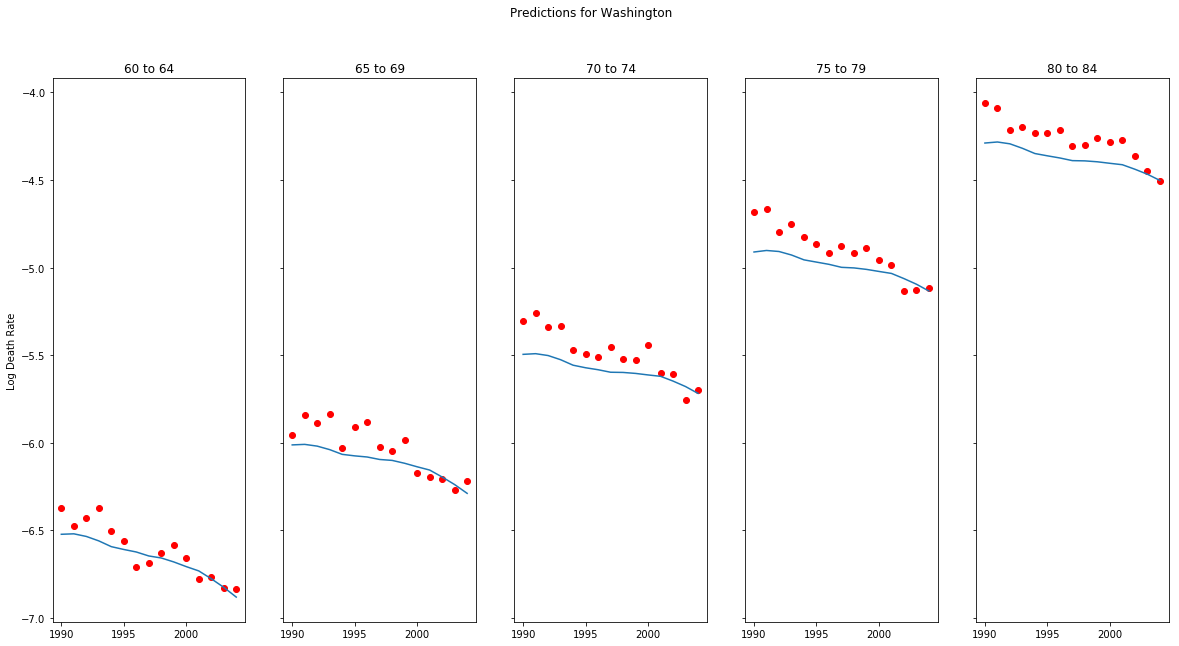

In [389]:
model.plot_predictions(df, querystring='location == "Washington"',
                       ages=['60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 to 84'])

In [373]:
model.rmse(df)

INFO:ensemble.submodel:Computing RMSE.


0.21545665378158987

##### Single Classifier Out-of-Sample Predictions

It looks like the model is doing a bit better with added covariates, but can we make it better? We could continue adding more and more covariates and random effects to make our RMSE smaller, but then we run the risk of **over-fitting** to our data. Over-fitting is what happens when we get really good predictions for the data that we used to fit the model because with enough parameters we can get the model to **perfectly hit all of the data points**. However, if we try to predict for places that we don't have data, our predictions will almost certainly be terrible. Additionally, if any of the covariates are collinear with one another (meaning that they are highly correlated), then the out-of-sample predictions may be highly unstable.

When assessing model performance, we really want to know about out-of-sample performance. We don't want our model to just be good at predicting the data points that were used in the fitting process. We want the model to be able to accurately predict heart disease mortality in places that *don't* have data based on the relationships that exist in places with data. In reality, datasets are not complete.

How can we simulate performance in places without data? We can remove whole groups of locations at a time, train the model on the places with data, and then see how well we do predicting for places where we've removed data. To do this, we will use a **random knockout process** that leaves out whole groups at a time from `scikit-learn` called `GroupShuffleSplit`. Let's run `GroupShuffleSplit` on our data frame **once** to split the data frame into a training and test set, leaving out full location time-series. We will default to using 70% of the data to train the model and 30% of the data to test the model.

In [374]:
train_list, test_list = utilities.split_groups(data_frame, n_splits=1, test_size=0.3, groups='location')

In [375]:
# fit the model on the training set and predict on the test set
model.fit(train_list[0])

Submodel(fixed_effects=['alcohol_lpc', 'diabetes_fpg', 'mean_BMI', 'mean_cholesterol', 'mean_SBP', 'pollution_indoor_total_prev', 'pollution_outdoor_pm25', 'pop_1500mplus_prop', 'smoking_prev', 'SEV_scalar_IHD', 'sdi', 'fruits_g_adj', 'nuts_seeds_g_adj', 'pufa_adj_pct', 'pulses_legumes_g_adj', 'haqi', 'tfa', 'ln_LDI_pc', 'ln_omega_3_g_adj', 'ln_vegetables_g_adj'],
     random_effects=['age'], response='ln_rate')

In [376]:
model.rmse(train_list[0])

INFO:ensemble.submodel:Computing RMSE.


0.21048223617143344

In [377]:
model.rmse(test_list[0])

INFO:ensemble.submodel:Computing RMSE.


0.23774787206039014

#### *The Ensemble Modeling Approach*

How can we construct a model that get's **better** out-of-sample performance? Ensemble modeling is the approach that we take for CODEm at IHME. There are various ways to construct an ensemble model, and some commonly known strategies have names like "boosting", and "random forests". For this teaching exercise, we will construct an ensemble model by thinking about lots of different classifiers that might be able to predict heart disease mortality, and then finding a smart way to combine the models in order to get the best predictions possible. We have created an object class called `Ensemble` that takes a list of classifiers, and then provides wrapper functions to the classifier functions like `Submodel.fit()`. In the next section, we will discuss one way to create that list of classifiers.

##### Creating Classifiers with Feature Selection

CODEm performs feature selection to determine which covariates to use. Commonly, feature selection involves modeling techniques such as the lasso, ridge regression, or forward/backward selection. These strategies result in a set of features, or covariates, that have been selected as "good" predictors of the outcome variable of interest. In the CODEm approach, modelers specify covariates that they think could be potentially associated with a cause of death, in this case heart disease mortality in females, like we did above. The modelers specify a degree of how associated a covariate is with heart disease. Level 1 covariates are covariates with strong biological associations with heart disease mortality. Level 2 and 3 covariates are more distantly related covariates. For this model, the modeler pre-specified the following covariates:

**Level 1**
* Mean cholesterol
* Mean systolic blood pressure
* Smoking prevalence
* SEV scalar (summary measure of risk exposure)

**Level 2**
* Prevalence of indoor pollution
* Prevalence of outdoor pollution (PM 2.5)
* Diabetes fasting plasma glucose
* Mean BMI
* Proportion of population living at 1500+ m
* Healthcare Access and Quality Index

**Level 3**
* Alcohol liters per capita consumed
* Lagged-Distributed Income per capita
* Avg. Omega-3 grams consumed
* Avg. Fruits grams consumed
* Avg. Nuts and seeds grams consumed
* Avg. Polyunsaturated fat grams consumed
* Avg. Pulses and legumes grams consumed
* Avg. Vegetables grams consumed
* Diet high in trans fatty acids

Then, the modeler specifies which direction the correlation should be in. For example, they would say that smoking should be positively correlated with heart disease mortality, and that fruit consumed should be negatively correlated with mortality. Or they can specify no prior direction. CODEm then tests each level 1 covariate independently with the outcome of interest and makes sure that it is both significant at the p=0.05 level and that the direction of the relationship matches what the modeler had as their prior belief (if it existed). If these match up, then combinations of level 1 covariates are similarly tested. CODEm then moves on to adding level 2 covariates one by one onto the level 1 classifiers to create another set of classifiers, and finishes with level 3. We have not replicated the feature selection here, but have loaded the result of the feature selection process so that we have a list of classifiers based on significant combinations of covariates.

In [378]:
# total number of classifiers/submodels
len(cv_names)

172

In [379]:
# look at a subset of the classifier fixed effects
cv_names[1:10]

[['mean_SBP'],
 ['SEV_scalar_IHD'],
 ['smoking_prev'],
 ['mean_cholesterol', 'SEV_scalar_IHD'],
 ['mean_cholesterol', 'smoking_prev'],
 ['mean_SBP', 'SEV_scalar_IHD'],
 ['mean_SBP', 'smoking_prev'],
 ['SEV_scalar_IHD', 'smoking_prev'],
 ['mean_SBP', 'SEV_scalar_IHD', 'smoking_prev']]

##### Constructing an Ensemble

Let's first create a list of classifiers based on the result of feature selection, using the log of the mortality rate (`ln_rate`) as our response variable.

In [380]:
classifiers = [Submodel(response='ln_rate', fixed_effects=cv, random_effects=['age']) for cv in cv_names]

Now we can create an ensemble object with the list of classifiers, and view the properties of the classifiers in the ensemble.

In [381]:
ensemble = Ensemble(classifiers)

In [382]:
# view the first several classifiers' parameters
ensemble.get_classifier_params()[1:5]

[{'fixed_effects': ['mean_SBP'],
  'random_effects': ['age'],
  'response': 'ln_rate'},
 {'fixed_effects': ['SEV_scalar_IHD'],
  'random_effects': ['age'],
  'response': 'ln_rate'},
 {'fixed_effects': ['smoking_prev'],
  'random_effects': ['age'],
  'response': 'ln_rate'},
 {'fixed_effects': ['mean_cholesterol', 'SEV_scalar_IHD'],
  'random_effects': ['age'],
  'response': 'ln_rate'}]

We need some way to combine the predictions from each of the classifiers. We will use RMSE, defined in the previous section, as a **metric for how well each of the classifiers does** at predicting heart disease mortality. Classifiers with a lower RMSE are doing *better* at predicting. We can now rank the classifiers based on their RMSE, with classifier #1 having the smallest RMSE, and then define a weighting scheme that converts the ranks to weights to be applied to each of the ensembles. We introduce a hyper-parameter, $\psi$, that determines how quickly these weights decline. For example, a $\psi = 1$ will have more evenly distributed weights, and a $\psi = 1.5$ will have relatively less evenly distributed weights. See the figure [here](https://pophealthmetrics.biomedcentral.com/articles/10.1186/1478-7954-10-1#Fig2) for an illustration of how the weights decline for varying $\psi$. Let the weight for the $i^{th}$ classifier out of $N$ total classifiers be given by

\begin{align*}
w_i = \frac{\psi^{N-rank_i}}{\sum_{j=1}^{n} \psi^{N-j}}
\end{align*}

where the $\sum_{i=1}^n w_i = 1$.

A commonly used value for $\psi$ is 1.2. We will now rank the submodels from their out-of-sample performance on the training-test sets that we had before for the single classifier, and assign them weights based on $\psi = 1.2$.

In [383]:
ensemble.rank(trainings=train_list, tests=test_list)

INFO:ensemble.ensemble:Ranking submodels
INFO:ensemble.ensemble:on training-test 1
INFO:ensemble.ensemble:Fitting classifier 0
INFO:ensemble.ensemble:Fitting classifier 1
INFO:ensemble.ensemble:Fitting classifier 2
INFO:ensemble.ensemble:Fitting classifier 3
INFO:ensemble.ensemble:Fitting classifier 4
INFO:ensemble.ensemble:Fitting classifier 5
INFO:ensemble.ensemble:Fitting classifier 6
INFO:ensemble.ensemble:Fitting classifier 7
INFO:ensemble.ensemble:Fitting classifier 8
INFO:ensemble.ensemble:Fitting classifier 9
INFO:ensemble.ensemble:Fitting classifier 10
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 11
INFO:ensemble.ensemble:Fitting classifier 12
INFO:ensemble.ensemble:Fitting classifier 13
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 14
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 15
INFO:ensemble.ensemble:Fitting classifier 16
INF

INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 147
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 148
INFO:ensemble.ensemble:Fitting classifier 149
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 150
INFO:ensemble.ensemble:Fitting classifier 151
INFO:ensemble.ensemble:Fitting classifier 152
INFO:ensemble.ensemble:Fitting classifier 153
INFO:ensemble.ensemble:Fitting classifier 154
INFO:ensemble.ensemble:Fitting classifier 155
INFO:ensemble.ensemble:Fitting classifier 156
INFO:ensemble.ensemble:Fitting classifier 157
INFO:ensemble.ensemble:Fitting classifier 158
INFO:ensemble.ensemble:Fitting classifier 159
INFO:ensemble.ensemble:Fitting classifier 160
INFO:ensemble.ensemble:Fitting classifier 161
INFO:ensemble.ensemble:Fitting classifier 162
INFO:ensemble.ensemble:Fitting classifier 163
INFO:ensemble.submodel:classifier failed to converge
INFO:e

Let's look at the ranks for each of the classifiers:

In [384]:
ensemble.ranks

array([118.,  84., 104., 131., 105., 130.,  80.,  97., 113.,  92., 149.,
        73.,  18., 172., 165.,  67.,  91.,  52., 163.,  48.,  95.,  50.,
        16.,  66., 161.,  54.,  49., 136., 151., 139.,  39., 108., 123.,
       127., 111., 132.,  53.,  32.,  23.,  36.,  44.,  26.,  27., 112.,
       100., 115., 125., 128., 119., 120., 129., 155., 138., 135.,  99.,
       109., 101., 103., 133., 126., 148., 134., 137.,  47.,  17.,  21.,
        29.,   8.,   7.,  28., 143., 106.,  65.,  69., 153., 107., 124.,
       146.,   5., 144., 102.,  14.,   4.,  59.,  64.,  75.,  74.,  71.,
        72.,  90.,  86.,   9.,  11.,   6., 169.,  10., 162.,  12.,  19.,
        98.,  55.,  57.,  58.,  61.,  68.,  63., 166.,  60.,  56.,  79.,
        88., 147.,  93.,  43.,  45.,  33.,  51.,  40.,  38.,  42.,  76.,
        87., 152.,  96., 154.,  89.,  94., 156., 157., 158., 159.,  62.,
        34., 171.,  41.,  30.,   1., 164.,   3.,   2., 167., 168.,  77.,
       170.,  25.,  70., 150., 160.,  35., 141.,  4

In [385]:
len(ensemble.classifiers)

172

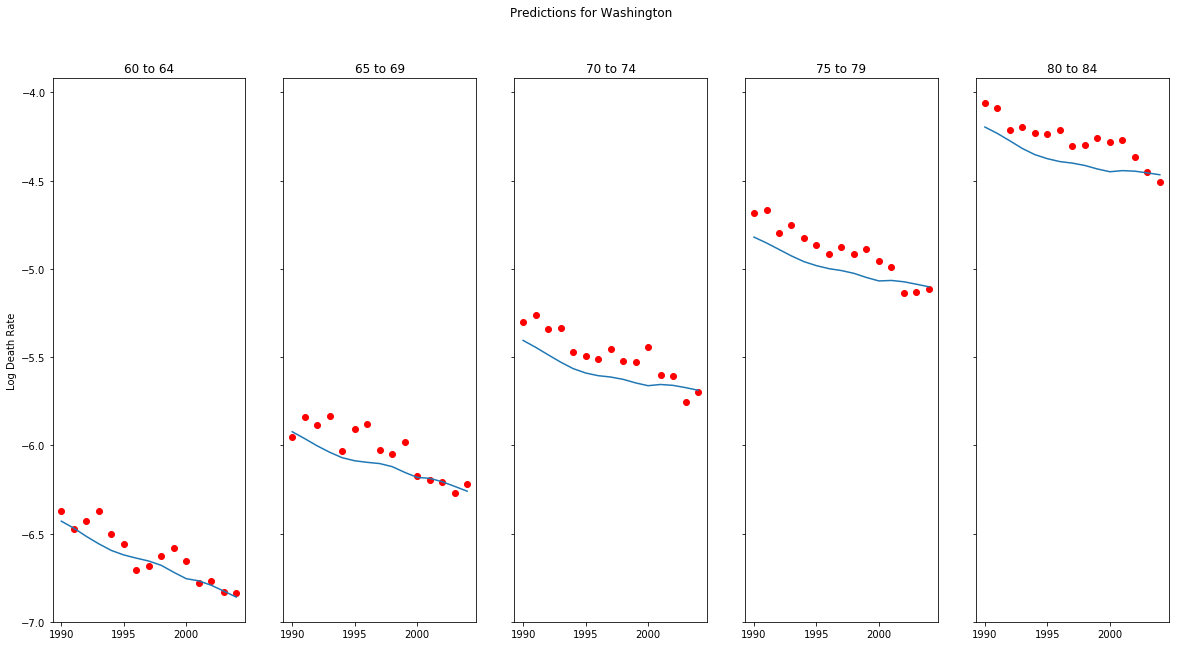

In [388]:
ensemble.classifiers[171].plot_predictions(df, querystring='location == "Washington"',
                       ages=['60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 to 84'])

##### Generating Draws for Uncertainty

Now we can combine the classifiers based on the weights given to them from these ranks and the above weighting scheme. A potential way to combine the submodels would be to multiply their predictions by their weight, and sum this over all of the submodels, i.e.:

\begin{align*}
\hat{y} = \sum_{i=1}^n \hat{y}_i \cdot w_i
\end{align*}

This may give a sensible point estimate, but we want to incorporate uncertainty from the parameter estimates. Instead, we set a number of desired "draws", usually chosen to be 1000 in the case of CODEm. Then we take $1000 \cdot w_i$ number of draws from classifier $i$. The method of creating a draw from a classifier means taking one sample from the variance-covariance matrix of the fixed effects estimates, multiplying that by the design matrix, $X$, and adding on the random effect for the group that each data point belongs to. Thus, if we have

\begin{align*}
\hat{\beta} \sim N_{p+1}(\beta, \Sigma)
\end{align*}

where $p$ is the number of features in the classifier and $\Sigma$ is the variance-covariance matrix of $\hat{\beta}$, we can take one realization of this multivariate normal distribution, and treat it as if it were the parameter estimates that we got from the `statsmodels.mixedlm` object. Because $\hat{\beta}$ is a random variable, multiple draws from the distribution will approximate this uncertainty. We can similarly take a draw from the random effects with $\hat{\upsilon} \sim N_r(\upsilon, \hat{\epsilon})$ and add that on to the prediction. In this case, we have 1000 draws total for the ensemble, with $1000*w_i$ draws from classifier $i$. Each draw is given by:

\begin{align*}
\hat{y}_{j_i} = X\hat{\beta}_{j_i} + Z\hat{\upsilon}_{j_i}
\end{align*}

We take the mean of all 1000 $\hat{y}_{j_i}$ to get our final $\hat{y}$. A 95% confidence interval is then given by the 2.75th and 97.5th percentiles of the 1000 draws. Here we will generate 1000 draws from the ensemble that we've created with the function `Ensemble.combine()`.

In [390]:
ensemble.combine(df=data_frame, n_draws=1000, psi=1.1)

INFO:ensemble.ensemble:Combining classifiers to create draws with psi 1.1.
INFO:ensemble.ensemble:moving on to refit block.
INFO:ensemble.ensemble:Refit == True
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to 

INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:en

INFO:ensemble.submodel:Refit yes
INFO:ensemble.submodel:Predictions!!
INFO:ensemble.submodel:Going to make n_draws 1
INFO:ensemble.submodel:Made the preds successfully!
INFO:ensemble.ensemble:Now we have draws!
INFO:ensemble.submodel:In the generate draws for submodel classifier.
INFO:ensemble.submodel:Refit yes
INFO:ensemble.submodel:Predictions!!
INFO:ensemble.submodel:Going to make n_draws 19
INFO:ensemble.submodel:Made the preds successfully!
INFO:ensemble.ensemble:Now we have draws!
INFO:ensemble.submodel:In the generate draws for submodel classifier.
INFO:ensemble.submodel:Refit yes
INFO:ensemble.submodel:Predictions!!
INFO:ensemble.submodel:Going to make n_draws 13
INFO:ensemble.submodel:Made the preds successfully!
INFO:ensemble.ensemble:Now we have draws!
INFO:ensemble.submodel:In the generate draws for submodel classifier.
INFO:ensemble.submodel:Refit yes
INFO:ensemble.submodel:Predictions!!
INFO:ensemble.submodel:Going to make n_draws 6
INFO:ensemble.submodel:Made the preds 

INFO:ensemble.submodel:Predictions!!
INFO:ensemble.submodel:Going to make n_draws 75
INFO:ensemble.submodel:Made the preds successfully!
INFO:ensemble.ensemble:Now we have draws!
INFO:ensemble.submodel:In the generate draws for submodel classifier.
INFO:ensemble.submodel:Refit yes
INFO:ensemble.submodel:Predictions!!
INFO:ensemble.submodel:Going to make n_draws 82
INFO:ensemble.submodel:Made the preds successfully!
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Now we have draws!
INFO:ensemble.submodel:In the generate draw

Let's look at our predictions now for this ensemble compared to the raw data.

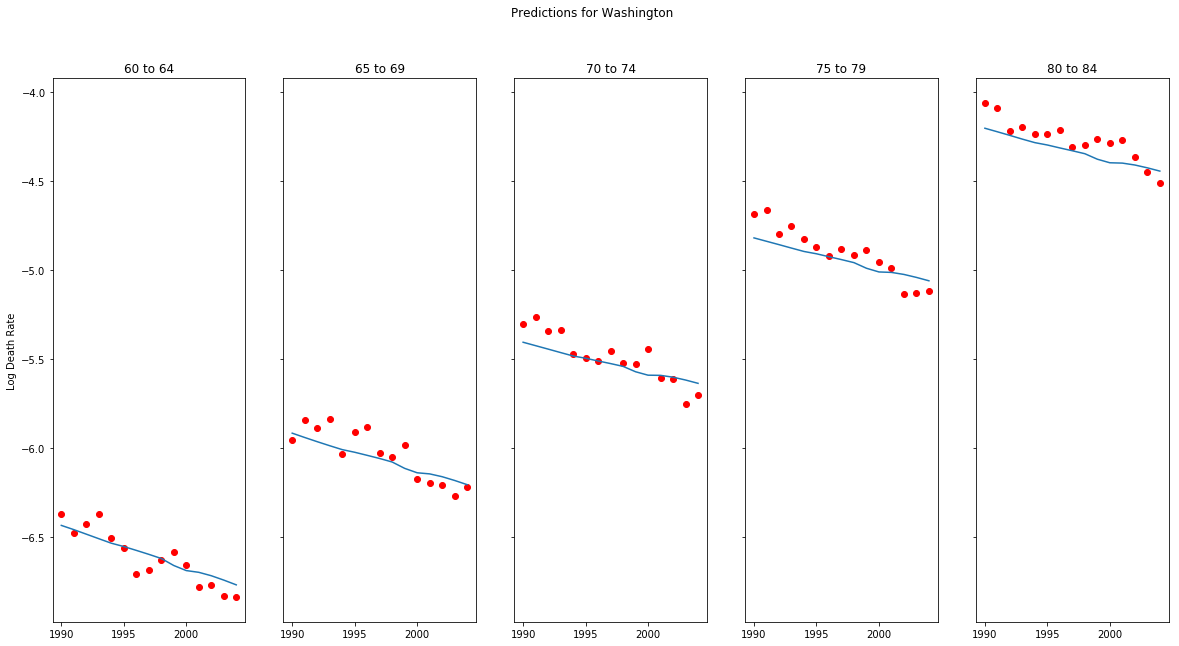

In [392]:
ensemble.plot_predictions(data_frame, response='ln_rate', querystring='location == "Washington"',
                       ages=['60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 to 84'])

In [393]:
# RMSE for overall ensemble on full dataset
ensemble.get_rmse([data_frame], n_draws=1000, response='ln_rate', refit=False)
ensemble.rmse

INFO:ensemble.ensemble:Combining classifiers to create draws with psi 1.2.
INFO:ensemble.ensemble:moving on to refit block.
INFO:ensemble.ensemble:next is valid classifiers.
INFO:ensemble.ensemble:Next is weights....
INFO:ensemble.ensemble:Next is new_weights...
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending wei

INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Now we have draws!
INFO:ensemble.submodel:In the generate draws for submodel classifier.
INFO:ensemble.submodel:Predictions!!
INFO:ensemble.submodel:Going to make n_draws 10
INFO:ensemble.submodel:Made the preds successfully!
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:en

INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ens

0.22569779975740015

##### Get Better Ensemble Predictions

To get better out-of-sample predictions, we will make multiple training-test sets. In this case, we rank submodels based on their **average OOS RMSE**. We can do this again with `GroupShuffleSplit`, and then `Ensemble.rank()` will rank submodels for a whole list of training-test pairs.

In [395]:
train_list, test_list = utilities.split_groups(data_frame, n_splits=10, test_size=0.3, groups='location')

In [396]:
# fit the model on the training set and predict on the test set
ensemble = Ensemble(classifiers)
ensemble.rank(train_list, test_list)

INFO:ensemble.ensemble:Ranking submodels
INFO:ensemble.ensemble:on training-test 1
INFO:ensemble.ensemble:Fitting classifier 0
INFO:ensemble.ensemble:Fitting classifier 1
INFO:ensemble.ensemble:Fitting classifier 2
INFO:ensemble.ensemble:Fitting classifier 3
INFO:ensemble.ensemble:Fitting classifier 4
INFO:ensemble.ensemble:Fitting classifier 5
INFO:ensemble.ensemble:Fitting classifier 6
INFO:ensemble.ensemble:Fitting classifier 7
INFO:ensemble.ensemble:Fitting classifier 8
INFO:ensemble.ensemble:Fitting classifier 9
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 10
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 11
INFO:ensemble.ensemble:Fitting classifier 12
INFO:ensemble.ensemble:Fitting classifier 13
INFO:ensemble.ensemble:Fitting classifier 14
INFO:ensemble.ensemble:Fitting classifier 15
INFO:ensemble.ensemble:Fitting classifier 16
INFO:ensemble.ensemble:Fitting classifier 17
INFO:ensemb

INFO:ensemble.ensemble:Fitting classifier 153
INFO:ensemble.ensemble:Fitting classifier 154
INFO:ensemble.ensemble:Fitting classifier 155
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 156
INFO:ensemble.ensemble:Fitting classifier 157
INFO:ensemble.ensemble:Fitting classifier 158
INFO:ensemble.ensemble:Fitting classifier 159
INFO:ensemble.ensemble:Fitting classifier 160
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 161
INFO:ensemble.ensemble:Fitting classifier 162
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 163
INFO:ensemble.ensemble:Fitting classifier 164
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 165
INFO:ensemble.ensemble:Fitting classifier 166
INFO:ensemble.ensemble:Fitting classifier 167
INFO:ensemble.ensemble:Fitting classifier 168
INFO:ensemble.submodel:classifier failed to converge

INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 6
INFO:ensemble.ensemble:Fitting classifier 7
INFO:ensemble.ensemble:Fitting classifier 8
INFO:ensemble.ensemble:Fitting classifier 9
INFO:ensemble.ensemble:Fitting classifier 10
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 11
INFO:ensemble.ensemble:Fitting classifier 12
INFO:ensemble.ensemble:Fitting classifier 13
INFO:ensemble.ensemble:Fitting classifier 14
INFO:ensemble.ensemble:Fitting classifier 15
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 16
INFO:ensemble.ensemble:Fitting classifier 17
INFO:ensemble.ensemble:Fitting classifier 18
INFO:ensemble.ensemble:Fitting classifier 19
INFO:ensemble.ensemble:Fitting classifier 20
INFO:ensemble.ensemble:Fitting classifier 21
INFO:ensemble.ensemble:Fitting classifier 22
INFO:ensemble.ensemble:Fitting classifier 23
INFO:ensemble.ensemble:Fitting clas

INFO:ensemble.ensemble:Fitting classifier 154
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 155
INFO:ensemble.ensemble:Fitting classifier 156
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 157
INFO:ensemble.ensemble:Fitting classifier 158
INFO:ensemble.ensemble:Fitting classifier 159
INFO:ensemble.ensemble:Fitting classifier 160
INFO:ensemble.ensemble:Fitting classifier 161
INFO:ensemble.ensemble:Fitting classifier 162
INFO:ensemble.ensemble:Fitting classifier 163
INFO:ensemble.ensemble:Fitting classifier 164
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 165
INFO:ensemble.ensemble:Fitting classifier 166
INFO:ensemble.ensemble:Fitting classifier 167
INFO:ensemble.ensemble:Fitting classifier 168
INFO:ensemble.ensemble:Fitting classifier 169
INFO:ensemble.ensemble:Fitting classifier 170
INFO:ensemble.ensemble:Fitting classifier 171
INFO:ensemble

INFO:ensemble.ensemble:Fitting classifier 10
INFO:ensemble.ensemble:Fitting classifier 11
INFO:ensemble.ensemble:Fitting classifier 12
INFO:ensemble.ensemble:Fitting classifier 13
INFO:ensemble.ensemble:Fitting classifier 14
INFO:ensemble.ensemble:Fitting classifier 15
INFO:ensemble.ensemble:Fitting classifier 16
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 17
INFO:ensemble.ensemble:Fitting classifier 18
INFO:ensemble.ensemble:Fitting classifier 19
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 20
INFO:ensemble.ensemble:Fitting classifier 21
INFO:ensemble.ensemble:Fitting classifier 22
INFO:ensemble.ensemble:Fitting classifier 23
INFO:ensemble.ensemble:Fitting classifier 24
INFO:ensemble.ensemble:Fitting classifier 25
INFO:ensemble.ensemble:Fitting classifier 26
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 27
INFO:ensemble.ensemble:Fitting 

INFO:ensemble.ensemble:Fitting classifier 159
INFO:ensemble.ensemble:Fitting classifier 160
INFO:ensemble.ensemble:Fitting classifier 161
INFO:ensemble.ensemble:Fitting classifier 162
INFO:ensemble.ensemble:Fitting classifier 163
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 164
INFO:ensemble.ensemble:Fitting classifier 165
INFO:ensemble.ensemble:Fitting classifier 166
INFO:ensemble.ensemble:Fitting classifier 167
INFO:ensemble.ensemble:Fitting classifier 168
INFO:ensemble.ensemble:Fitting classifier 169
INFO:ensemble.ensemble:Fitting classifier 170
INFO:ensemble.ensemble:Fitting classifier 171
INFO:ensemble.ensemble:Computing classifier RMSE
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Comp

INFO:ensemble.ensemble:Fitting classifier 16
INFO:ensemble.ensemble:Fitting classifier 17
INFO:ensemble.ensemble:Fitting classifier 18
INFO:ensemble.ensemble:Fitting classifier 19
INFO:ensemble.ensemble:Fitting classifier 20
INFO:ensemble.ensemble:Fitting classifier 21
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 22
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 23
INFO:ensemble.ensemble:Fitting classifier 24
INFO:ensemble.ensemble:Fitting classifier 25
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 26
INFO:ensemble.ensemble:Fitting classifier 27
INFO:ensemble.ensemble:Fitting classifier 28
INFO:ensemble.ensemble:Fitting classifier 29
INFO:ensemble.ensemble:Fitting classifier 30
INFO:ensemble.ensemble:Fitting classifier 31
INFO:ensemble.ensemble:Fitting classifier 32
INFO:ensemble.ensemble:Fitting classifier 33
INFO:ensemble.ensemble:Fitting 

INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Co

INFO:ensemble.ensemble:Fitting classifier 29
INFO:ensemble.ensemble:Fitting classifier 30
INFO:ensemble.ensemble:Fitting classifier 31
INFO:ensemble.ensemble:Fitting classifier 32
INFO:ensemble.ensemble:Fitting classifier 33
INFO:ensemble.ensemble:Fitting classifier 34
INFO:ensemble.ensemble:Fitting classifier 35
INFO:ensemble.ensemble:Fitting classifier 36
INFO:ensemble.ensemble:Fitting classifier 37
INFO:ensemble.ensemble:Fitting classifier 38
INFO:ensemble.ensemble:Fitting classifier 39
INFO:ensemble.ensemble:Fitting classifier 40
INFO:ensemble.ensemble:Fitting classifier 41
INFO:ensemble.ensemble:Fitting classifier 42
INFO:ensemble.ensemble:Fitting classifier 43
INFO:ensemble.ensemble:Fitting classifier 44
INFO:ensemble.ensemble:Fitting classifier 45
INFO:ensemble.ensemble:Fitting classifier 46
INFO:ensemble.ensemble:Fitting classifier 47
INFO:ensemble.ensemble:Fitting classifier 48
INFO:ensemble.ensemble:Fitting classifier 49
INFO:ensemble.ensemble:Fitting classifier 50
INFO:ensem

INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Co

INFO:ensemble.ensemble:Fitting classifier 40
INFO:ensemble.ensemble:Fitting classifier 41
INFO:ensemble.ensemble:Fitting classifier 42
INFO:ensemble.ensemble:Fitting classifier 43
INFO:ensemble.ensemble:Fitting classifier 44
INFO:ensemble.ensemble:Fitting classifier 45
INFO:ensemble.ensemble:Fitting classifier 46
INFO:ensemble.ensemble:Fitting classifier 47
INFO:ensemble.ensemble:Fitting classifier 48
INFO:ensemble.ensemble:Fitting classifier 49
INFO:ensemble.ensemble:Fitting classifier 50
INFO:ensemble.ensemble:Fitting classifier 51
INFO:ensemble.ensemble:Fitting classifier 52
INFO:ensemble.ensemble:Fitting classifier 53
INFO:ensemble.ensemble:Fitting classifier 54
INFO:ensemble.ensemble:Fitting classifier 55
INFO:ensemble.ensemble:Fitting classifier 56
INFO:ensemble.ensemble:Fitting classifier 57
INFO:ensemble.ensemble:Fitting classifier 58
INFO:ensemble.ensemble:Fitting classifier 59
INFO:ensemble.ensemble:Fitting classifier 60
INFO:ensemble.ensemble:Fitting classifier 61
INFO:ensem

INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Co

INFO:ensemble.ensemble:Fitting classifier 40
INFO:ensemble.ensemble:Fitting classifier 41
INFO:ensemble.ensemble:Fitting classifier 42
INFO:ensemble.ensemble:Fitting classifier 43
INFO:ensemble.ensemble:Fitting classifier 44
INFO:ensemble.ensemble:Fitting classifier 45
INFO:ensemble.ensemble:Fitting classifier 46
INFO:ensemble.ensemble:Fitting classifier 47
INFO:ensemble.ensemble:Fitting classifier 48
INFO:ensemble.ensemble:Fitting classifier 49
INFO:ensemble.ensemble:Fitting classifier 50
INFO:ensemble.ensemble:Fitting classifier 51
INFO:ensemble.ensemble:Fitting classifier 52
INFO:ensemble.ensemble:Fitting classifier 53
INFO:ensemble.ensemble:Fitting classifier 54
INFO:ensemble.ensemble:Fitting classifier 55
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 56
INFO:ensemble.ensemble:Fitting classifier 57
INFO:ensemble.ensemble:Fitting classifier 58
INFO:ensemble.ensemble:Fitting classifier 59
INFO:ensemble.ensemble:Fitting classifier 60
IN

INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Co

INFO:ensemble.ensemble:Fitting classifier 46
INFO:ensemble.ensemble:Fitting classifier 47
INFO:ensemble.ensemble:Fitting classifier 48
INFO:ensemble.ensemble:Fitting classifier 49
INFO:ensemble.ensemble:Fitting classifier 50
INFO:ensemble.ensemble:Fitting classifier 51
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 52
INFO:ensemble.ensemble:Fitting classifier 53
INFO:ensemble.ensemble:Fitting classifier 54
INFO:ensemble.ensemble:Fitting classifier 55
INFO:ensemble.ensemble:Fitting classifier 56
INFO:ensemble.ensemble:Fitting classifier 57
INFO:ensemble.ensemble:Fitting classifier 58
INFO:ensemble.ensemble:Fitting classifier 59
INFO:ensemble.ensemble:Fitting classifier 60
INFO:ensemble.ensemble:Fitting classifier 61
INFO:ensemble.ensemble:Fitting classifier 62
INFO:ensemble.ensemble:Fitting classifier 63
INFO:ensemble.ensemble:Fitting classifier 64
INFO:ensemble.ensemble:Fitting classifier 65
INFO:ensemble.ensemble:Fitting classifier 66
IN

INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Co

INFO:ensemble.ensemble:Fitting classifier 47
INFO:ensemble.ensemble:Fitting classifier 48
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 49
INFO:ensemble.ensemble:Fitting classifier 50
INFO:ensemble.ensemble:Fitting classifier 51
INFO:ensemble.ensemble:Fitting classifier 52
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 53
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 54
INFO:ensemble.ensemble:Fitting classifier 55
INFO:ensemble.ensemble:Fitting classifier 56
INFO:ensemble.ensemble:Fitting classifier 57
INFO:ensemble.ensemble:Fitting classifier 58
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 59
INFO:ensemble.ensemble:Fitting classifier 60
INFO:ensemble.ensemble:Fitting classifier 61
INFO:ensemble.ensemble:Fitting classifier 62
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.e

INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Co

INFO:ensemble.ensemble:Fitting classifier 43
INFO:ensemble.ensemble:Fitting classifier 44
INFO:ensemble.ensemble:Fitting classifier 45
INFO:ensemble.ensemble:Fitting classifier 46
INFO:ensemble.ensemble:Fitting classifier 47
INFO:ensemble.ensemble:Fitting classifier 48
INFO:ensemble.ensemble:Fitting classifier 49
INFO:ensemble.ensemble:Fitting classifier 50
INFO:ensemble.ensemble:Fitting classifier 51
INFO:ensemble.ensemble:Fitting classifier 52
INFO:ensemble.ensemble:Fitting classifier 53
INFO:ensemble.ensemble:Fitting classifier 54
INFO:ensemble.ensemble:Fitting classifier 55
INFO:ensemble.ensemble:Fitting classifier 56
INFO:ensemble.ensemble:Fitting classifier 57
INFO:ensemble.ensemble:Fitting classifier 58
INFO:ensemble.ensemble:Fitting classifier 59
INFO:ensemble.ensemble:Fitting classifier 60
INFO:ensemble.ensemble:Fitting classifier 61
INFO:ensemble.ensemble:Fitting classifier 62
INFO:ensemble.ensemble:Fitting classifier 63
INFO:ensemble.ensemble:Fitting classifier 64
INFO:ensem

INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Co

INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:next is valid classifiers.
INFO:ensemble.ensemble:Next is weights....
INFO:ensemble.ensemble:Next is new_weights...
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ens

INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ens

INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ens

ValueError: need at least one array to concatenate

In [397]:
ensemble.combine(data_frame, n_draws=1000, psi=1.1, refit=False)

INFO:ensemble.ensemble:Combining classifiers to create draws with psi 1.1.
INFO:ensemble.ensemble:moving on to refit block.
INFO:ensemble.ensemble:next is valid classifiers.
INFO:ensemble.ensemble:Next is weights....
INFO:ensemble.ensemble:Next is new_weights...
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending wei

INFO:ensemble.submodel:Made the preds successfully!
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Now we have draws!
INFO:ensemble.submodel:In the generate draws for submodel classifier.
INFO:ensemble.submodel:Predictions!!
INFO:ensemble.submodel:Going to make n_draws 26
INFO:ensemble.submodel:Made the preds successfully!
INFO:ensemble.ensemble:Now we have draws!
INFO:ensemble.submodel:In the generate draws for submodel classifier.
INFO:ensemble.submodel:Predictions!!
INFO:ensemble.submodel:Going to make n_draws 17
INFO:ensemble.submodel:Made the preds successfully!
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.en

INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ens

Our final predictions would be given the refitting the dataset, but with the combination of submodels that we chose to have best OOS predictive validity, so we can be sure that we're not over-fitting the data, and are making the best predictions that we can in the absence of data.

In [398]:
ensemble.get_rmse([data_frame], n_draws=1000, response='ln_rate', refit=False)
ensemble.rmse

INFO:ensemble.ensemble:Combining classifiers to create draws with psi 1.2.
INFO:ensemble.ensemble:moving on to refit block.
INFO:ensemble.ensemble:next is valid classifiers.
INFO:ensemble.ensemble:Next is weights....
INFO:ensemble.ensemble:Next is new_weights...
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Weights is None!!!
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending weights
INFO:ensemble.ensemble:Appending wei

INFO:ensemble.submodel:Predictions!!
INFO:ensemble.submodel:Going to make n_draws 15
INFO:ensemble.submodel:Made the preds successfully!
INFO:ensemble.ensemble:Now we have draws!
INFO:ensemble.submodel:In the generate draws for submodel classifier.
INFO:ensemble.submodel:Predictions!!
INFO:ensemble.submodel:Going to make n_draws 7
INFO:ensemble.submodel:Made the preds successfully!
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no dr

INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ensemble.ensemble:Don't want to continue since no draws.
INFO:ens

0.2289443295911618

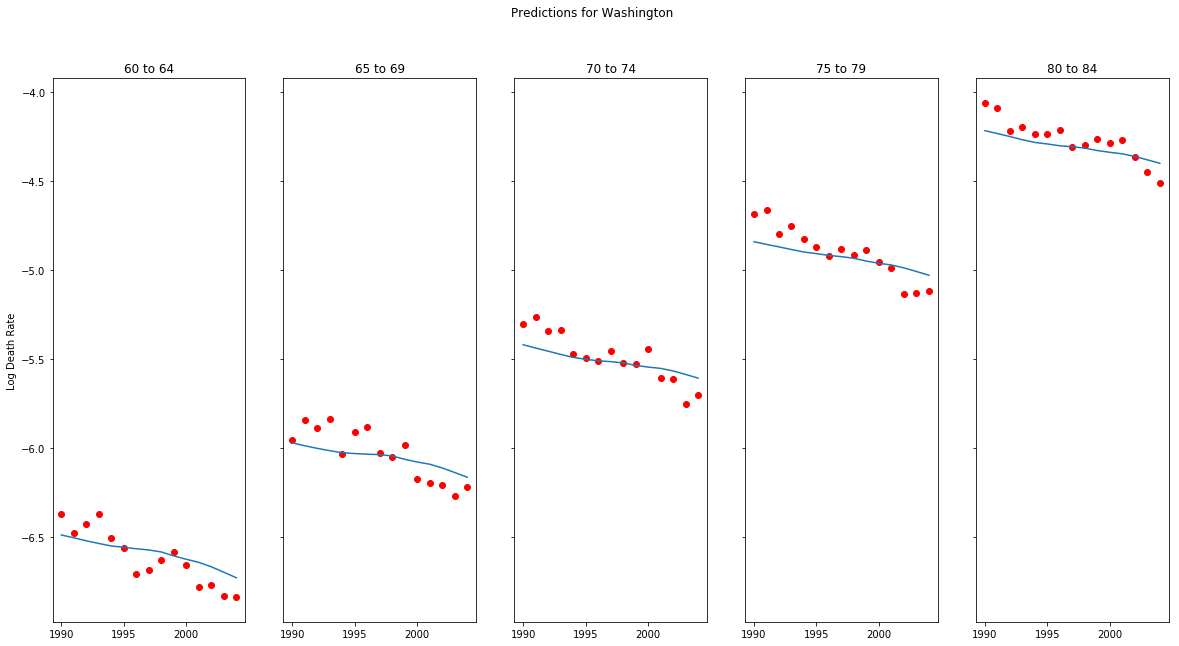

In [405]:
ensemble.plot_predictions(data_frame, response='ln_rate', querystring='location == "Washington"',
                       ages=['60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 to 84'])

##### Why we use ensembles: compare the ensemble RMSE to the **BEST** classifier RMSE

In order to make a fair comparison of our ensemble to the best submodel, we need to make sure they are evaluated on the **same amount of training and test data**. Because the ensemble actually uses the performance of the submodel on the 30% of test data to optimally rank the submodels, it would not be accurate to look at its performance on the test set.

Instead we will create multiple sets of training-test1-test2, where each test set has 15% of the data, and the training has 70%. Then the submodels in the ensemble will be fit on 70% of the data, tested for the ranks on 15% of the data, and then RMSE for the entire ensemble evaluated on the last 15% of the data that it hasn't seen yet. We will then train the best submodel from the ensemble on 85% of the data made up of training and test1, and then test its performance on the same 15% of the data that the ensemble is evaluated on. This way, both the ensemble and the best submodel see the same 85% of the data, and are evaluated on the same 15% of the data, across multiple knockouts.

First, let's create the 70-30 split:

In [401]:
train_list, test_list = utilities.split_groups(data_frame, n_splits=10, test_size=0.3, groups='location')

Now let's split each test dataframe into one list of 50-50, test1 and test2.

In [403]:
test1_list = []
test2_list = []
for test in test_list:
    test1, test2 = utilities.split_groups(test, n_splits=1, test_size=0.5, groups='location')
    test1_list.append(test1[0])
    test2_list.append(test2[0])

And we want to use training + test1 to create a list for the best submodel to be trained on.

In [404]:
submodel_train_list = []
for test, train1 in zip(train_list, test1_list):
    submodel_train_list.append(pd.concat([test, train1]))

Let's construct our ensemble on the test and train 1 set, and then get the average RMSE for test2 across all knockouts:

In [ ]:
ensemble = Ensemble(classifiers)
ensemble.rank(train_list, test1_list)

INFO:ensemble.ensemble:Ranking submodels
INFO:ensemble.ensemble:on training-test 1
INFO:ensemble.ensemble:Fitting classifier 0
INFO:ensemble.ensemble:Fitting classifier 1
INFO:ensemble.ensemble:Fitting classifier 2
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 3
INFO:ensemble.ensemble:Fitting classifier 4
INFO:ensemble.ensemble:Fitting classifier 5
INFO:ensemble.ensemble:Fitting classifier 6
INFO:ensemble.ensemble:Fitting classifier 7
INFO:ensemble.ensemble:Fitting classifier 8
INFO:ensemble.ensemble:Fitting classifier 9
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 10
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 11
INFO:ensemble.ensemble:Fitting classifier 12
INFO:ensemble.ensemble:Fitting classifier 13
INFO:ensemble.ensemble:Fitting classifier 14
INFO:ensemble.ensemble:Fitting classifier 15
INFO:ensemble.ensemble:Fitting classifier 16
INF

INFO:ensemble.ensemble:Fitting classifier 147
INFO:ensemble.ensemble:Fitting classifier 148
INFO:ensemble.ensemble:Fitting classifier 149
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 150
INFO:ensemble.ensemble:Fitting classifier 151
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 152
INFO:ensemble.ensemble:Fitting classifier 153
INFO:ensemble.ensemble:Fitting classifier 154
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 155
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 156
INFO:ensemble.ensemble:Fitting classifier 157
INFO:ensemble.ensemble:Fitting classifier 158
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 159
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 160
INFO:ensemble.ensemble:Fitting classif

INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.submodel:Computing RMSE.
INFO:ensemble.ensemble:on training-test 2
INFO:ensemble.ensemble:Fitting classifier 0
INFO:ensemble.ensemble:Fitting classifier 1
INFO:ensemble.ensemble:Fitting classifier 2
INFO:ensemble.ensemble:Fitting classifier 3
INFO:ensemble.ensemble:Fitting classifier 4
INFO:ensemble.ensemble:Fitting classifier 5
INFO:ensemble.ensemble:Fitting classifier 6
INFO:ensemble.ensemble:Fitting classifier 7
INFO:ensemble.ensemble:Fitting classifier 8
INFO:ensemble.ensemble:Fitting classifier 9
INFO:ensemble.ensemble:Fitting classifier 10
INFO:ensemble.ensemble:Fitting classifier 11
INFO:ensemble.ensemble:Fitting classifier 12
INFO:ensemble.submodel:classifier failed to converge
INFO:ensemble.ensemble:Fitting classifier 13
INFO:ensemble.ensemble:Fitting classifier 14
INFO:e

In [ ]:
ensemble.ranks

In [ ]:
ensemble.get_rmse(test2_list, n_draws=1000, response='ln_rate', psi=1.1, refit=False)

In [ ]:
ensemble.ranks.tolist().index(1)

In [ ]:
ensemble.rmse

Now we will switch to using the submodel train list and the test2 to evaluate the best submodel. We can find the best submodel by pulling it from the ensemble ranks.

In [ ]:
ensemble = Ensemble(classifiers)
ensemble.rank(submodel_train_list, test2_list)
best_index = ensemble.ranks.tolist().index(1)
best_classifier = classifiers[best_index]

In [ ]:
best_classifier

How does this classifier do in terms of RMSE when it has access to 85% of the data, across all knockouts?

In [ ]:
best_classifier.rmse_mean(submodel_train_list, test2_list)

**Indeed, the ensemble is better than the best submodel in terms of out-of-sample RMSE!**